In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PIX2PIX

In “*Image-to-Image Translation with Conditional Adversarial Networks*”, Phillip Isola,Jun-Yan Zhu, Tinghui Zhou and Alexei A. Efros describe a conditional GAN that learns a mapping from an input image to an output image and a loss function to train this mapping. The conditioning on the mapping is not application specific (inpainting, reconstruction from edges etc.) and is only learned from the training data pairs .



The objective function is composed of a conditional GAN loss and L1 loss:
$$G* = \min_{G} \max_{D} L_{cGAN}(G,D)+L_{L1}(G)$$
where:
 $$L_{cGAN}(G,D) = Ex,y[log D(x,y)]+Ex,z[log (1-D(x,G(x,z))]$$  
and
$$L_{L1}(G) = Ex,y,z[||y-G(x,z)||_1]$$  



In practice,  the generator  maximizes  log (D(x,G(x,z)))  instead of
 minimizing log(1-D(x,G(x,z))) and the discriminator loss is divided to slow down its learning.

In our setting, reverberated RTFs are passed in the generator to create dereverberated
RTF-Phase (fakes).
These fakes are then compared to the true-clean RTFs using the discriminator, conditioned on the reverberated RTFs, that way we get the adversarial loss.
In addition, the L1 loss is gained by simply taking the L1 norm of the generated dereverberated-RTF-Phase with the true-clean RTF-Phase.

In [3]:
project_dir = '/content/drive/MyDrive/תואר שני  הנדסה מדעי הנתונים/קורסים/מודלים גנרטיביים עמוקים/Final Project/Final_Project/'

### Imports

In [4]:
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from tqdm import tqdm

### Constants

In [15]:
root_dir = project_dir + 'Fixed Data/'
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 64
# Number of training epochs
num_epochs = 3
# Learning rate for optimizer
lr = 0.0002
# Number of channels in the training images. For color images this is 3
nc = 1
# Size of feature maps in generator
ngf = 32
# Size of feature maps in discriminator
ndf = 32
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data

In [6]:
class CustomImageDataset(Dataset):
    """"""
    def __init__(self, root_dir, is_test=False, normalize=False, split_parts=False):
        """
        :param root_dir:
        :param is_test:
        :param normalize: If not False, should be a nd.array of the form
         np.array([mean_left,std_left,mean_right,std_right])
        """
        dirs = os.listdir(root_dir)
        dirs = [dir for dir in dirs if dir.startswith('Test') == is_test]
        self.revs = None
        self.targets = None

        for dir in dirs:
            rev_target_dirs = os.listdir(os.path.join(root_dir, dir))
            rev_dir = [d for d in rev_target_dirs if d.startswith('beta = 0.160')][0]
            target_dir = [d for d in rev_target_dirs if d.startswith('Target')][0]
            rev = os.path.join(root_dir, dir, rev_dir, 'data_phase.npy' if is_test else 'data_phase.npy')
            a = np.load(rev)

            if self.revs is None:
                self.height = a.shape[1]
                self.width = a.shape[2]
                if split_parts:
                    self.width = self.width // 2

            if normalize is not False:
                a[:,:,:self.width//2] = (a[:,:,:self.width//2] - normalize[0])/normalize[1]
                a[:,:,self.width//2:] = (a[:,:,self.width//2:] - normalize[2])/normalize[3]

            if split_parts:
                a = np.concatenate([a[:, :, :125], a[:, :, 125:]], axis=0)

            if self.revs is None:
                self.revs = np.copy(a)
            else:
                self.revs = np.vstack((self.revs, a))
            target = os.path.join(root_dir, dir, target_dir, 'data_phase.npy')
            b = np.load(target)

            if split_parts:
                b = np.concatenate([b[:, :, :125], b[:, :, 125:]], axis=0)

            if self.targets is None:
                self.targets = np.copy(b)
            else:
                self.targets = np.vstack((self.targets, b))

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        """"""
        reverberated_image = self.revs[idx, :, :] / np.pi
        target_image = self.targets[idx, :, :] / np.pi
        pad = 128 - self.width

        reverberated_image = np.pad(reverberated_image, ((0, 0), (pad, 0)), 'constant', constant_values=0)
        target_image = np.pad(target_image, ((0, 0), (pad, 0)), 'constant', constant_values=0)

        reverberated_image = reverberated_image.reshape(1, 7, -1)
        target_image = target_image.reshape(1, 7, -1)
        return torch.from_numpy(reverberated_image), torch.from_numpy(target_image)

## Architecture

### U-Net Based Generator

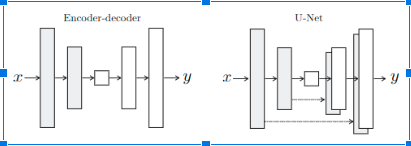


Many image-to-image translation uses Encoder-Decoder based architectures for the generator. This kind of architecture enables a detailed image as an input and a detailed image as an output while the bottleneck encapsulates enough data to generate the output image. 
But in many image-to-image scenarios the input and output image share data that need not be transformed at all and we want to allow  this kind of data to skip the bottleneck. For this end a U-Net architecture is used where skip connections between equal level layers between down-sample and up-sample enable unchanged data to pass through


### Downsample Module

In [7]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(7,4), strides=(1,2), padding=1, activation=True, batchnorm=True,
                 bias=True, name=''):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.name = name
        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding='valid', bias=bias, dtype=torch.float64)
        self.padding = padding
        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels, dtype=torch.float64)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = F.pad(x, (0, 0, 3, 3), mode='circular')
        x = F.pad(x, (self.padding, self.padding, 0, 0), mode='constant')
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x



### Upsample Module

In [8]:
class UpSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(3,4), strides=(1,2), padding=1, activation=True, batchnorm=True,
                 dropout=False,name=''):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.name = name

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding=(1,1), dtype=torch.float64)
        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels, dtype=torch.float64)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.3)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x


### Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()
        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, ngf, kernel=(7,4), strides=(1, 2), padding=1, batchnorm=False, name='encoder1'),  # bs x 64 x 7 x 64
            DownSampleConv(ngf, ngf * 2, kernel=(7,4), strides=(1, 2), padding=1, name='encoder2'),  # bs x 128 x 7 x 32
            DownSampleConv(ngf * 2, ngf * 4, kernel=(7,4), strides=(1, 2), padding=1, name='encoder3'),  # bs x 256 x 7 x 16
            DownSampleConv(ngf * 4, ngf * 8, kernel=(7,4), strides=(1, 2), padding=1, name='encoder4'),  # bs x 512 x 7 x 8
            DownSampleConv(ngf * 8, ngf * 8, kernel=(7,4), strides=(1, 2), padding=1, name='encoder5'),  # bs x 512 x 7 x 4
            DownSampleConv(ngf * 8, ngf * 8, kernel=(7,4), strides=(1, 2), padding=1, name='encoder6'),  # bs x 512 x 7 x 2
            DownSampleConv(ngf * 8, ngf * 8, kernel=(7,4), strides=(1, 2), padding=1, name='encoder7'),  # bs x 512 x 7 x 1
        ]

        self.decoders = [
            UpSampleConv(ngf * 8, ngf*8, strides=(1, 2), padding=1, dropout=True, name='decoder1'), # bs x 512 x 7 x 2
            UpSampleConv(ngf * 16, ngf*8, strides=(1, 2), padding=1, dropout=True, name='decoder2'), # bs x 512 x 7 x 4
            UpSampleConv(ngf * 16, ngf*8, strides=(1, 2), padding=1, dropout=True, name='decoder3'), # bs x 512 x 7 x 8
            UpSampleConv(ngf * 16, ngf*8, strides=(1, 2), padding=1, dropout=False, name='decoder4'), # bs x 512 x 7 x 16
            UpSampleConv(384, ngf*4, strides=(1, 2), padding=1, dropout=False, name='decoder5'), # bs x 512 x 7 x 32
            UpSampleConv(192, ngf*2, strides=(1, 2), padding=1, dropout=False, name='decoder6'), # bs x 512 x 7 x 64
        ]
        self.final_conv = nn.ConvTranspose2d(2*ngf, out_channels, kernel_size=(3,4), stride=(1,2), padding=(1, 1),dtype=torch.float64)
        self.tanh = nn.Tanh()
        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)
            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        x = self.final_conv(x)
        return self.tanh(x)


### PatchGAN Module


The discriminator used in pix2pix is called PatchGAN because it penalizes only at patch level – high level true\fake judgment. This is done using the L1 term that forces low-frequency correctness. The discriminator looks at N*N patches and decides for each patch whether it is true or fake. N may be much smaller than image size. As a result PatchGAN  models the image as a Markov Random Field (MRF) . The smaller N is PatchGAN runs faster and can be applied to large images


In [10]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, ndf, kernel=(7,4), strides=(1, 2), padding=1, bias=False, name='patchgan1')  # channels: 1->64
        self.d2 = DownSampleConv(ndf, ndf * 2, kernel=(7,4), strides=(1, 2), padding=1, bias=False, name='patchgan2')  # channels: 64->128
        self.d3 = DownSampleConv(ndf * 2, ndf * 4, kernel=(7,4), strides=(1, 2), padding=1, bias=False, name='patchgan3')  # channels: 128->256
        self.d4 = DownSampleConv(ndf * 4, ndf * 8, kernel=(7,4), strides=(1, 2), padding=1, bias=False, name='patchgan4')  # channels: 256->512
        self.final = nn.Conv2d(ndf * 8, 1, kernel_size=(7, 4), stride=(1, 1), padding=1, bias=False,dtype=torch.float64)  # channels: 512->1

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn



Module Weight Initialization Utility

In [11]:
def _weights_init(m):
    """
    :param m: nn.Module to preform initialization on
    """
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

### PIX2PIX  network

In [12]:
class Pix2Pix(nn.Module):

    def __init__(self, in_channels, out_channels, device, learning_rate=0.0002, lambda_recon=200):
        super().__init__()
        self.device = device
        self.gen = Generator(in_channels, out_channels).to(device)
        self.patch_gan = PatchGAN(in_channels + out_channels).to(device)
        self.lambda_recon = lambda_recon
        self.lr = learning_rate

        # initializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

        self.D_losses_vs_epochs = []
        self.G_losses_vs_epochs = []
        self.epoch = 0

    @property
    def generator(self):
        return self.gen

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)

        return adversarial_loss + self.lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)
        real_logits = self.patch_gan(real_images, conditioned_images)
        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr=self.lr)
        self.disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=self.lr)
        return self.disc_opt, self.gen_opt

    def train_model(self, device, train_dataloader, epochs, save_every=None, save_dir=None):

        self.gen.train()  # set to training mode
        self.patch_gan.train()  # set to training mode
        self.D_losses, self.G_losses = [], []
        epoch_bar = tqdm(range(1, epochs + 1), desc='Epoch Loop', position=0, leave=True)
        for _ in epoch_bar:
            self.epoch += 1
            for batch_idx, inputs in tqdm(enumerate(train_dataloader), desc='Mini-batch Loop',
                                          total=len(train_dataloader), position=1, leave=False):
                condition, real = inputs
                real = real.to(self.device)
                condition = condition.to(self.device)
                self.gen.zero_grad()
                self.patch_gan.zero_grad()

                # Train patch discriminator
                disc_loss = self._disc_step(real_images=real, conditioned_images=condition)
                disc_loss.backward()
                self.D_losses.append(disc_loss)
                self.disc_opt.step()

                # Train generator
                gen_loss = self._gen_step(real_images=real, conditioned_images=condition)
                gen_loss.backward()
                self.G_losses.append(gen_loss)
                self.gen_opt.step()
            epoch_bar.set_description('Epoch[%d]: Loss Disc: %.3f, Loss Gen: %.3f'
                  % (self.epoch, torch.mean(torch.FloatTensor(self.D_losses)), torch.mean(torch.FloatTensor(self.G_losses))))

            self.G_losses_vs_epochs.append(torch.mean(torch.FloatTensor(self.G_losses)))
            self.D_losses_vs_epochs.append(torch.mean(torch.FloatTensor(self.D_losses)))

            if save_every is not None and not self.epoch % save_every:
                self.save_model(save_dir=save_dir)


    def save_model(self,save_dir=None, final=False):
        if save_dir is None:
            save_dir = ''
        elif not save_dir.endswith('/'):
            save_dir += '/'
        if final:
            save_dir += 'Final: '

        torch.save({'epoch': self.epoch, 'model_state_dict': self.gen.state_dict(),
                    'optimizer_state_dict': self.gen_opt.state_dict(), 'Gen_losses': self.G_losses_vs_epochs, },
                   save_dir + f'Gen_Epoch_{self.epoch}_loss_{self.G_losses_vs_epochs[-1]:.3f}.pt')
        torch.save({'epoch': self.epoch, 'model_state_dict': self.patch_gan.state_dict(),
                    'optimizer_state_dict': self.disc_opt.state_dict(), 'Disc_losses': self.D_losses_vs_epochs, },
                   save_dir + f'Disc_Epoch_{self.epoch}_loss_{self.D_losses_vs_epochs[-1]:.3f}.pt')
        return

    def load_model(self, gen_path, disc_path):
        """

        :param gen_path: path to generator state_dict
        :param disc_path: path to discriminator state_dict
        :return: The model generator, discriminator, optimizers and epoch attributes are loaded with the
        parameters from the state_dicts.
        """

        if not (hasattr(self, 'gen_opt') and hasattr(self, 'disc_opt')):
            self.configure_optimizers()

        gen_state_dict = torch.load(gen_path, map_location=device)
        self.epoch = gen_state_dict.get('epoch')
        self.gen.load_state_dict(gen_state_dict.get('model_state_dict'))
        self.gen_opt.load_state_dict(gen_state_dict.get('optimizer_state_dict'))
        self.G_losses_vs_epochs = gen_state_dict.get('Gen_losses')


        disc_state_dict = torch.load(disc_path, map_location=device)
        self.patch_gan.load_state_dict(disc_state_dict.get('model_state_dict'))
        self.disc_opt.load_state_dict(disc_state_dict.get('optimizer_state_dict'))
        self.D_losses_vs_epochs = disc_state_dict.get('Disc_losses')

        return


    def test(self, batch):
        """
        :param batch: batch of images loaded on device, to feed into the generator. Dims: [batch_size, 1, 7, 128]
        :return: output is returned on cpu
        """
        # TODO
        self.gen.eval()
        with torch.no_grad():
            generated = self.gen(batch)
            generated = generated.detach().cpu()
        return generated

    def get_n_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        number_params = sum([np.prod(p.size()) for p in model_parameters])
        return number_params


## Train

### Datasets and loaders

 - Initialize datasets
 - Initialize dataloaders
 - Plot samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


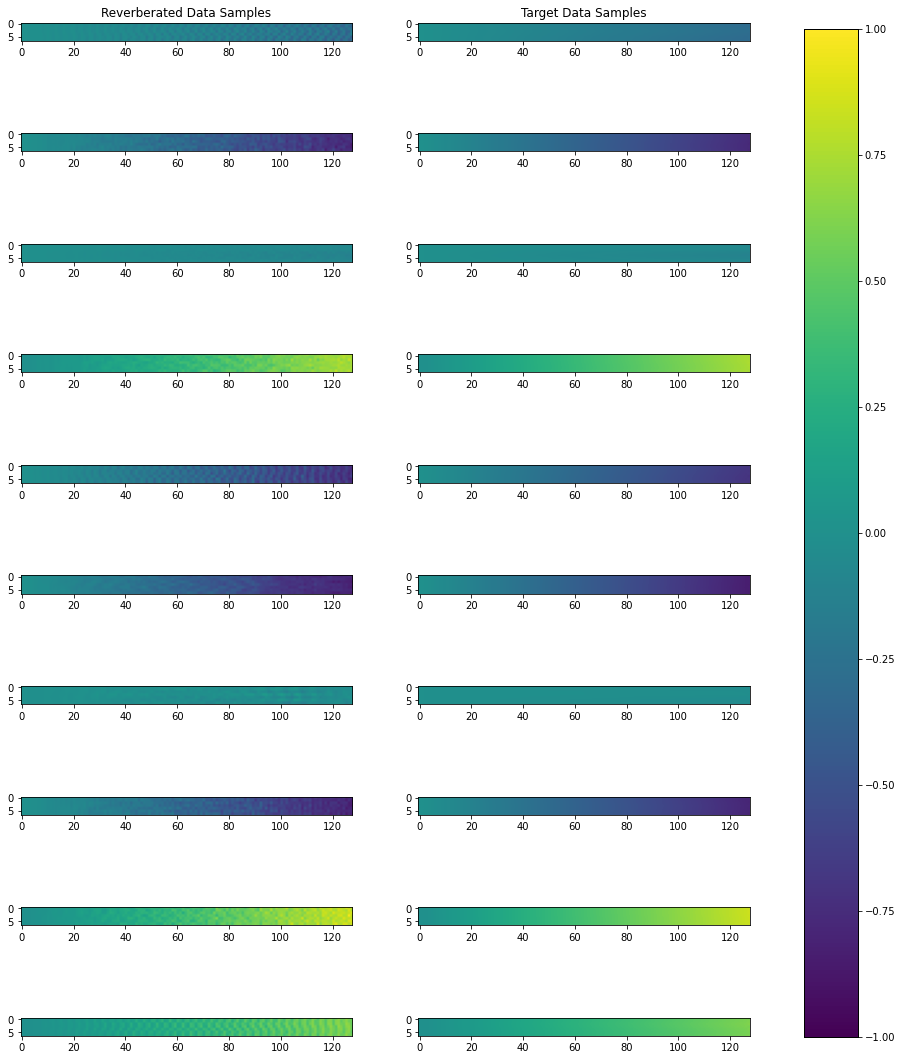

In [13]:
# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Dataset and Dataloader
training_data = CustomImageDataset(root_dir, split_parts=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=workers)

# Plot a some training images and their targets:
train_rev, train_target = next(iter(train_dataloader))
fig, axes = plt.subplots(10,2, figsize=(15,20))

l = []
for i in range(10):
    l.append(train_rev[i].squeeze())
    l.append(train_target[i].squeeze())

for j, (ax, im) in enumerate(zip(axes.ravel(), l)):
    m=ax.imshow(im)
    m.set_clim(vmin=-1, vmax=1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(m, cax=cbar_ax)
    if j == 0:
        ax.set_title('Reverberated Data Samples')
    if j == 1:
        ax.set_title('Target Data Samples')
plt.show()


## Train Model

In [16]:
adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()
lambda_recon = 200

pix2pix = Pix2Pix(nc, nc,device=device, learning_rate=lr, lambda_recon=lambda_recon)
pix2pix.configure_optimizers()

save_path = project_dir + 'Pix2Pix/Pix2Pix_lambda_recon=200/'
# pix2pix.train(device,train_dataloader, epochs=num_epochs)
pix2pix.train_model(device,train_dataloader, epochs=num_epochs)
pix2pix.save_model(save_dir=save_path)


Epoch[3]: Loss Disc: 0.469, Loss Gen: 8.761: 100%|██████████| 3/3 [1:34:55<00:00, 1898.62s/it]


### Plot Learning Curve

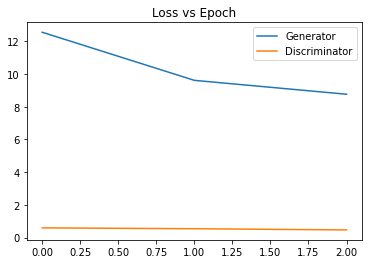

In [17]:
# Plot Generator and Discriminator learning curves:
fig = plt.figure()
gen_losses = [a.cpu() for a in pix2pix.G_losses_vs_epochs]
disc_losses = [a.cpu() for a in pix2pix.D_losses_vs_epochs]
plt.plot(gen_losses)
plt.plot(disc_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss vs Epoch')
fig.savefig(save_path + 'learning_curve_40.png')


## Test

### Datasets and loader

- Initialize datasets
- Initialize dataloaders
- Plot samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


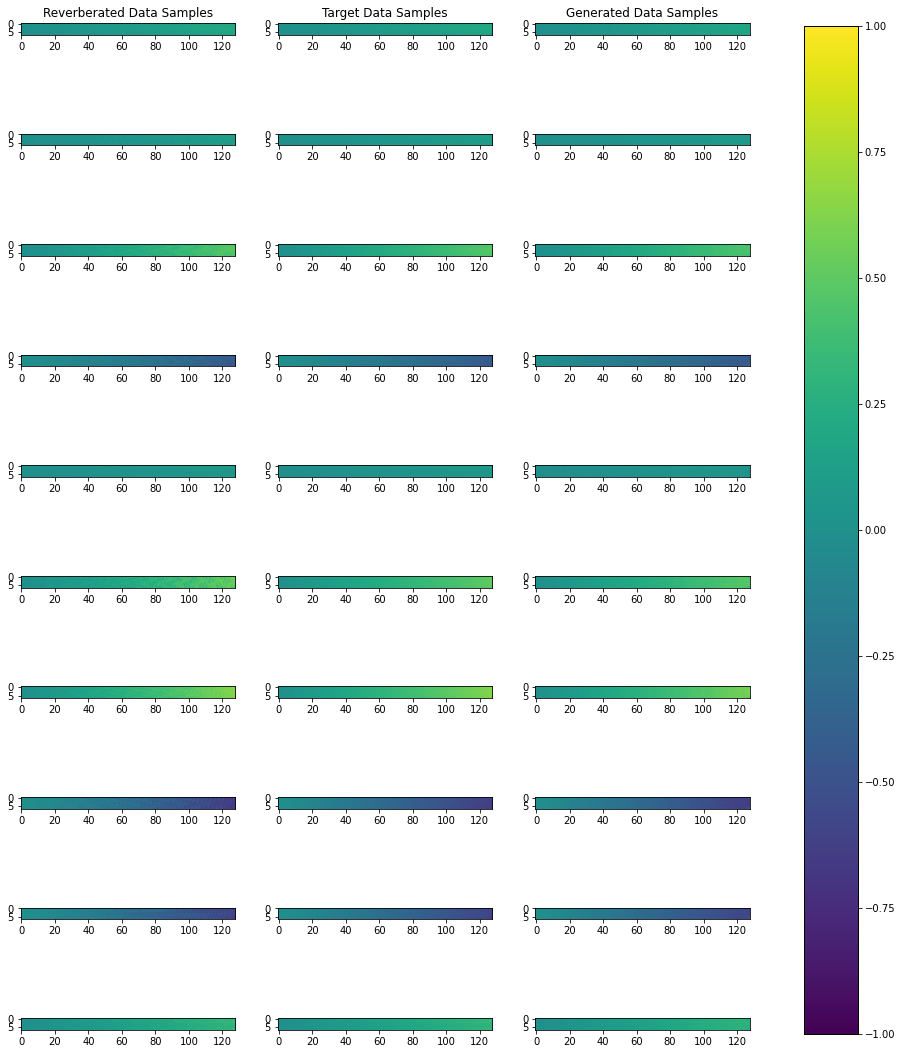

In [18]:
test_data = CustomImageDataset(root_dir, is_test=True,split_parts=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

##### Plot test images
test_rev, test_target = next(iter(test_loader))
test_rev = test_rev.to(device)
test_generated = pix2pix.test(test_rev)
fig, axes = plt.subplots(10,3, figsize=(15,20))
l = []
for i in range(10):
    l.append(test_rev[i].cpu().squeeze())
    l.append(test_target[i].squeeze())
    l.append(test_generated[i].squeeze())

for j, (ax, im) in enumerate(zip(axes.ravel(), l)):
    m=ax.imshow(im)
    m.set_clim(vmin=-1, vmax=1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(m, cax=cbar_ax)
    if j == 0:
        ax.set_title('Reverberated Data Samples')
    if j == 1:
        ax.set_title('Target Data Samples')
    if j == 2:
        ax.set_title('Generated Data Samples')
plt.show()

## Apply generator on test data, and show the output

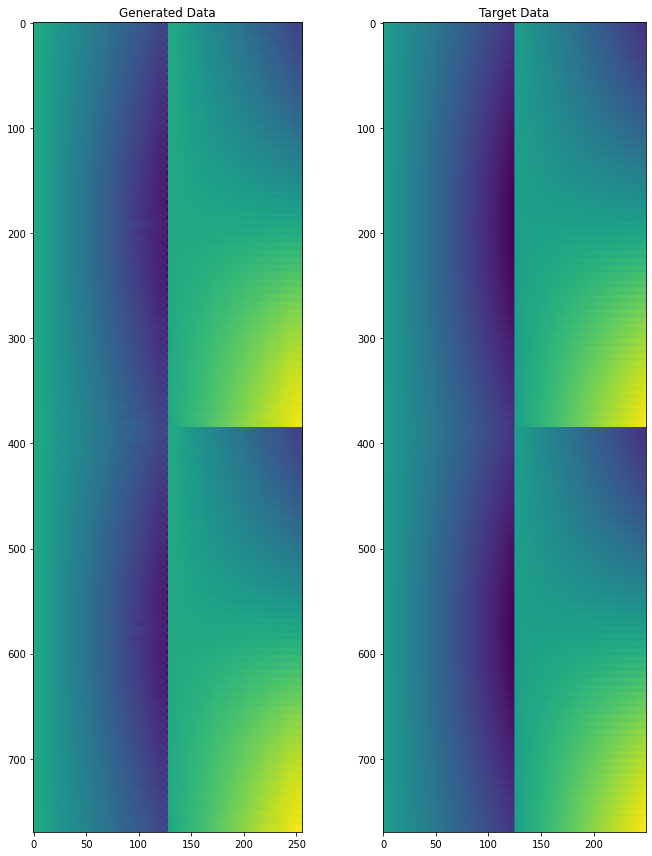

In [19]:
data_loadpath = root_dir + 'Test - room=[6,6,2.4], src=[3,3,1.2]/beta = 0.160/data_phase.npy'
data = np.load(data_loadpath)
data_savepath = project_dir + '/Pix2Pix/Pix2Pix_lambda_recon=200/Cleaned_Test_Data_beta=0.160_src=[3,3,1.2]/'
# Normalizing to range [-1,1]
data = data/np.pi

data_left = data[:,:,:125]
data_right = data[:,:,125:]

data_left = np.pad(data_left, ((0, 0),(0,0), (3, 0)), 'constant', constant_values=0)
data_right = np.pad(data_right, ((0, 0),(0,0), (3, 0)), 'constant', constant_values=0)

data_left_torch = torch.tensor(data_left).reshape([data_left.shape[0], 1, data_left.shape[1],data_left.shape[2]]).to(device)
data_right_torch = torch.tensor(data_right).reshape([data_left.shape[0], 1, data_left.shape[1],data_left.shape[2]]).to(device)

data_generated_left = np.zeros([data.shape[0],7,128])
data_generated_right = np.zeros([data.shape[0],7,128])
# Due to lack in gpu memory - apply in batches:
for k in range(data.shape[0]//batch_size):
    data_generated_left[k*batch_size:(k+1)*batch_size] = np.squeeze(pix2pix.gen(data_left_torch[k*batch_size:(k+1)*batch_size]).detach().cpu().numpy())
    data_generated_right[k*batch_size:(k+1)*batch_size] = np.squeeze(pix2pix.gen(data_right_torch[k*batch_size:(k+1)*batch_size]).detach().cpu().numpy())


data_generated = np.concatenate([data_generated_left,data_generated_right], axis=2)

# plt.figure()
fig, ax = plt.subplots(1,2, figsize=(10,12))
ax[0].imshow(data_generated.reshape([-1,256])[:770])
ax[0].set_title('Generated Data')
# compare with target data:
target_data_path = root_dir + 'Test - room=[6,6,2.4], src=[3,3,1.2]/Target (gpuRIR)/data_phase.npy'

target_data = np.load(target_data_path)
target_data = target_data / np.pi  # Apply the same normalization we did to training data
ax[1].imshow(target_data.reshape([-1,250])[:770])
ax[1].set_title('Target Data')
plt.tight_layout()